## Домашняя работа №1 Part1
Вам предстоит:

Написать персептрон с двумя слоями. Реализовать форвард и бэквард пропогейшен



In [32]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

# Датасет
Загрузим Мнист. Почему именно он? Мы будем решать задачу бинарной классификации на паре цифр: 3 и 7. Плюсы в том, что примеров для этих чисел достаточно, чтобы обучить НС, у каждого примера не так много фичей (28Х28 - размерность картинок) и, в целом, эти классы хорошо отделяются. Я б с радостью показал вам пример с текстами, но если писать НС с нуля и пытаться обучаться на текстах, не факт, что у нас хоть что то обучится :(  
  

Торч - объект, который позволяет нормализовать картинки, можно думать о нем как о предобработке (регулярках) для текстов. В целом не стоит здесь долго думать

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Загружаем датасет. Возращается особенный торчовый класс, чуть ниже мы зададим его сами и научимся им полльзоваться, пока оставляем эз из.


In [34]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

Выбираем два класса. Если вы достаточно хорошо знакомы с пандас, то можно понять, что никакой магии здесь нет.

In [35]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

Мы неоднократно говорили, что НС обычно тренируются бачами, в торче есть удобный класс, который позволяет обернуть наши датасеты в итерируемый объект. Если не знаете что такое итерируемый объект, погуглите :) можно думать об этом как о списке с составными элементами (элемент - батч - набор примеров)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [37]:
X, y = next(iter(train_loader)) #next(iter(x) - Возвращает следующий элемент итератора.
X

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [38]:
y

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0])

Никакой магии, просто многомерные матрицы. Можно даже проверить, что то, что мы получили, то есть первый батч имееет правильную размерность.В y - 1 это класс цифры "7", 0 - "3"

In [39]:
X.shape #128 - примеров, [1, 28, 28] - размерность картинки, 1 - значит что из трех каналов (Р, Г, Б) у нас всего один, а сама картинка 28 на 28

torch.Size([128, 1, 28, 28])

In [40]:
y.shape

torch.Size([128])

Проверим, правда ли это картинки

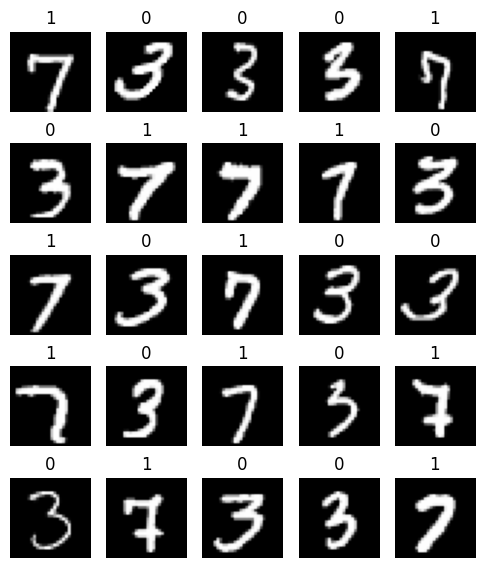

In [41]:
X, y = next(iter(train_loader))
X = X.numpy() # перевод тензора в массив нумпай, просто изменение типа данных
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Нам столько размерностей не нужно, поэтому давайте выпрямим матрицу, тем боле мы знаем что значение каждого пикселя независимо друг друга.

In [42]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)   # аааа 784 = 28*28 = количество пикселей = количество фичей (?)
X.shape

torch.Size([128, 784])

 Размерность
- количество примеров в батче
- количество фичей

In [43]:
y

tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1])

Такой У нам не совсем подходит. Сейчас объясню почему. Размерность Х (128,784) матрично перемножим на скрытый слой (784,1) и получится (128,1). Нужно понимать, что размерность (128,) и (128,1) это немного разные вещи  

In [44]:
w = torch.rand(784, 1) #Рандомные необученые веса
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [45]:
pred

tensor([[ -0.3874],
        [ 70.4703],
        [ -9.3489],
        [-95.2952],
        [  5.7843],
        [-13.6376],
        [ 14.8386],
        [ 56.8109],
        [ 13.1302],
        [-33.6949],
        [-23.1202],
        [-14.4694],
        [ -0.3773],
        [ -1.0837],
        [ 41.3915],
        [-70.9478],
        [-19.6047],
        [ -8.3985],
        [-31.7427],
        [ 42.3881],
        [ 12.2960],
        [-28.2158],
        [-17.8604],
        [ -7.3567],
        [ 47.7014],
        [-45.2891],
        [-44.6976],
        [ 57.3288],
        [-21.0254],
        [ 75.9579],
        [ 53.9878],
        [-46.0846],
        [-13.9488],
        [ 25.8157],
        [-38.1241],
        [-11.3006],
        [ 59.6857],
        [-43.3863],
        [ 16.0594],
        [ 30.0508],
        [ 85.6578],
        [ 53.1648],
        [ -2.8463],
        [-82.1283],
        [  0.1496],
        [ 14.2220],
        [-88.4717],
        [-59.2566],
        [-21.0474],
        [-28.3283],


Теперь у нас есть предсказания и их размерность (128,1). Нужно будет счтить лосс с у, поэтому приведем его к такой же размерности с expand_dims - это функция есть в нумпае, также есть и в торче

In [46]:
y = np.expand_dims(y, 1)

In [47]:
y

array([[1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

Итерация по эпохам

In [48]:
epochs = 3 # получается тут мы просто 3 круга как перекидываем данные из даталоадера все и ничего с ними не делаем

for n_epoch in range(epochs):

    dataset_passed_samples = 0

    for x, y in train_loader:

        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет

        time.sleep(0.05)

        dataset_passed_samples += x.shape[0]

        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]

        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')

    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Однослойный персептрон

In [49]:
learning_rate = 0.01 # тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 5  #сколько раз мы пройдем по всему тренировачному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
n_feat = 784

w1 = np.random.rand(n_feat,1)*0.01 #0.01 - нормируем таким образом наши веса, чтобы избежать деления на ноль при бэкпропе,
                                    #эмпирически выбрано, так как сами фичи у нас имеют значения близкие к 0
b1 = np.zeros(1) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения

losses = [] #на каждой итерации (и для всех эпох) будем сохранять сюда наш Лосс, чтобы видеть обучается ли НС

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)

        h1 = x.dot(w1) + b1 #переход в одномерное пространство = по одному результату на каждый входной элемент hidden = kx+b
        p = 1/(1+np.exp(-h1)) #преобразование в "вероятности" = нелинейность (?) или нет = сигмодида получается

        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size # ооо это получается лосс!
        #расчет энтропии с усреднением по размеру бача

        # а тут идёт уже backward получатеся, а в двуслойном было бы ещё вперед и длиннее backward

        losses.append(bce) # да, логично, что это лосс
        #ниже производная bce и sigmoid, если вы распишите две этих производные, перемножите и сократите, то получится следующая строчка
        dp = (p - y) / batch_size
        dw1 = np.dot(x.T, dp) # производная по линейному преобразванию, относительно W - весов
        db1 = np.sum(dp) # производная по лин преобразованиюб относительно В - баяса,
        #здесь по идее должно быть перемножение на единичный вектор (128,1), но это тоже самое что и сумма значениеб типа лайф хак life hack остался непонят чё...

        w1 -= learning_rate * dw1 # Обновим веса и баясы
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


А теперь построим график функции потерь

Text(0, 0.5, 'Loss function')

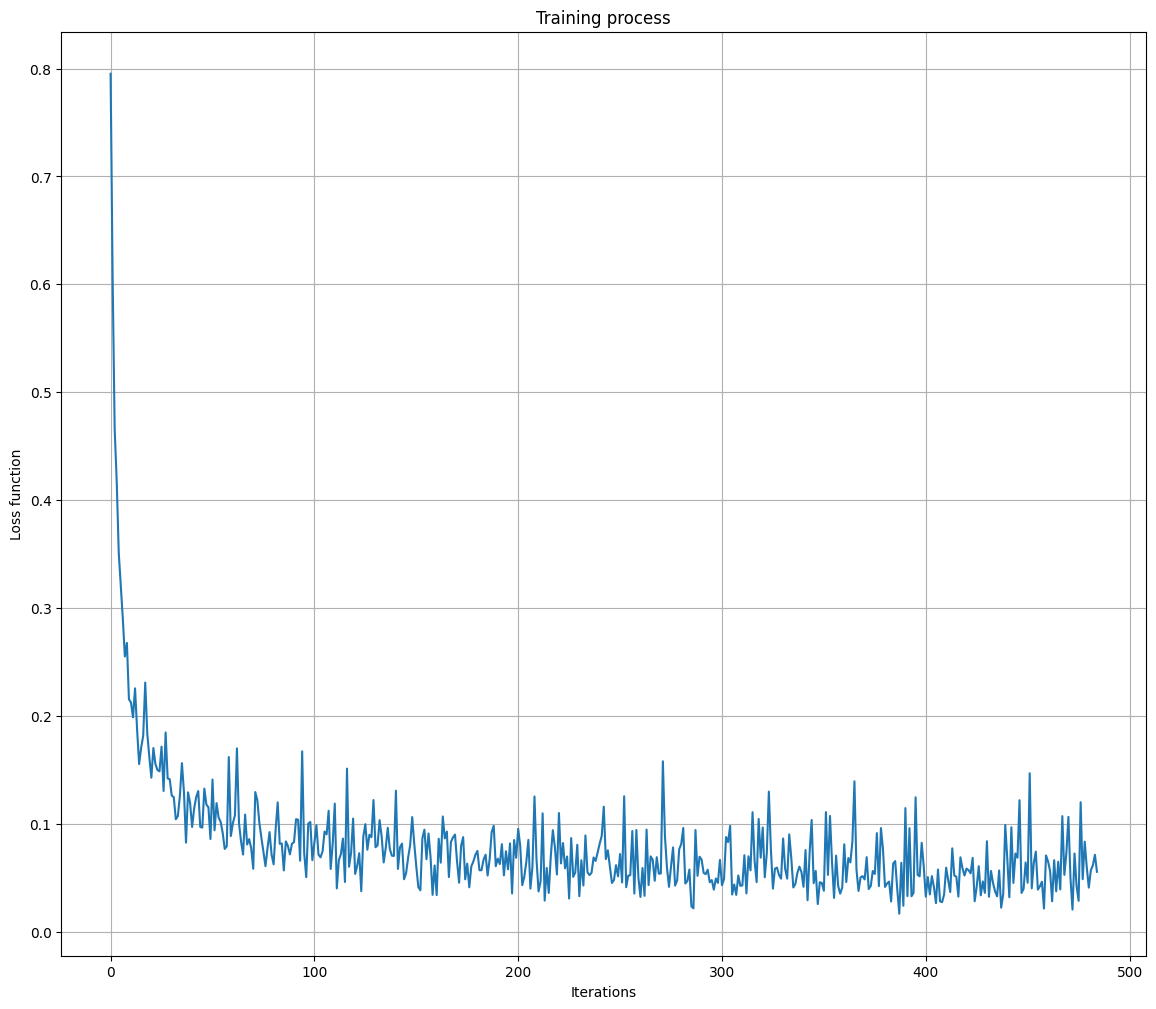

In [50]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Математика


![alt text](https://sun9-39.userapi.com/c850608/v850608777/47a4/fgZlI898IUU.jpg)
![alt text](https://sun9-41.userapi.com/c858216/v858216777/cc4f5/v3CPa-tnm80.jpg)
![alt text](https://sun9-67.userapi.com/c857632/v857632471/f6e95/H0dsmWsUInc.jpg)
![alt text](https://sun9-71.userapi.com/c858120/v858120274/10d0ef/hdKO-3Syk3g.jpg)



А теперь ваша очередь, нужно написать двуслоный персептрон, согласно коду и выкладкам выше

**Upd:** я так искренне сожалею, какая же я тупая

**Upd:** мне надо доделать только часть со взятием производной по нелинейности

In [68]:
### КОД СЮДА ###

learning_rate = 0.01 # почему бы и нет
epochs = 5 # пока маленькое количество, чтобы не тяжело было факапить

batch_size = 128  # опять же, почему бы и нет
in_feat = 784 # у нас же тот же датасет? значит в целом те же картинки 28 на 28
inner_feat = 420 # просто любое базированное число
out_feat = 1 # мы типа хотим ответ уже: это 7 или это не 7 = это 3

w1 = np.random.rand(in_feat,inner_feat)*0.01 # кстати, как умножение на 0.01 нам помогает не поделить случайно на 0  я пока не поняла (ТУТ ДОЛЖНЫЙ БЫТЬ ДРУГИЕ ВЕСА)
b1 = np.zeros(inner_feat) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения - то есть в прошлый раз это было что-то ближе к концу, а сейчас у нас это только середина
w2 = np.random.rand(inner_feat, out_feat)*0.01
b2 = np.zeros(out_feat)

losses = [] # мы ведь потим потом график красивенький

# Х * W = (128, 784) * (784, 1) => размер
# w1 (in_feat, inner_feat)  in = 784 inner = 150 (а именно любоооое число)
# я чё-то не могу собраться и посчиать что происходит с размерностями внутри сигмоды то есть вероятности то есть нелинейности))))
# w2 (inner_feat, out_feat) inner = 150 out = 1


for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)

        ### КОД СЮДА ###
        # 1. forward, вперёд
        z1 = x.dot(w1) + b1 #переход в inner пространство
        a1 = 1/(1+np.exp(-z1)) # первая нелинейность
        z2 = a1.dot(w2) + b2 # переход в пространство ответов
        pred = 1/(1+np.exp(-z2)) # вторая нелинейность = predictions = ответы = предсказания = можн было бы назвать a2
        #print(x.shape) (128, 784)
        #print(w1.shape) (784, 420)
        #print(z1.shape) (128, 420)
        #print(a1.shape) (128, 420)
        #print(w2.shape) (420, 1)
        #print(z2.shape) (128, 1)
        #print(pred.shape) (128, 1)
        #print(y.shape) (128, 1)

        # 2. рассчет bce = то есть посчитать лосс = то есть посчитать ошибку и добавить её к лоссам
        bce = (-np.sum(np.multiply(np.log(pred), y) + np.multiply((1 - y), np.log(1 - pred)))) / batch_size # ооо это получается лосс!
        losses.append(bce)

        #print(bce.shape) (784, 420) - не поняла чего это так много там вроде обещан скаляр но не важно

        # 3. backward = то есть какое-то количество производных
        # я ИСКРЕННЕ не понимаю, как брать производные, но достаточно интуитивно, что последниq слой тут будет работать так, как единственный в однослойном, только со смещением типа
        dpred = (pred - y)/batch_size # (128, 1) = (BATCH_SIZE, 1)
        dw2 = np.dot(a1.T, dpred) # ура! действительно (420, 1) = (INNER_FEATURES, 1)
        db2 = np.sum(dpred) # действительно (1,)

        # И вот так самая средняя часть, которую я НЕ поняла по конспектам 2 месяца назад
        dz1 = dpred * (w2.T * (a1 * (1 - a1)))

        # и потом оно передаётся назад и уже высчитывается
        dw1 = np.dot(X.T, dz1) # (784, 128) (128, 420) = (784, 420) = (in_feat, inner_feat)
        db1 = np.sum(dz1)

             # то есть нам как минимум нужно прийти к 4-ырём выражениям

        # 4. gradient descent, чёёёёёёёёёёё я думала это уже backward!! или это типа обновить веса
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w1 -= learning_rate * dw1 # Обновим веса и баясы, нам жалко что ли
        b1 -= learning_rate * db1

Epoch: 1


ValueError: ignored

In [78]:
### КОД СЮДА ###

learning_rate = 0.01 # тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 10  #сколько раз мы пройдем по всему тренировачному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
in_feat = 784
inner_feat = 420 # просто любое базированное число
out_feat = 1 # бнарный ответ 7 не 7

w1 = np.random.rand(in_feat,inner_feat)*0.01
b1 = np.zeros(inner_feat)
w2 = np.random.rand(inner_feat,out_feat)*0.01
b2 = np.zeros(out_feat)

losses = []

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)

        ### КОД СЮДА ###
        # 1. forward, вперёд
        z1 = x.dot(w1) + b1 #переход в inner пространство
        a1 = 1/(1+np.exp(-z1)) # первая нелинейность
        z2 = a1.dot(w2) + b2 # переход в пространство ответов
        pred = 1/(1+np.exp(-z2)) # вторая нелинейность - предсказания уже

        # 2. рассчет bce = то есть посчитать лосс
        bce = (-np.sum(np.multiply(np.log(pred), y) + np.multiply((1 - y), np.log(1 - pred)))) / batch_size
        losses.append(bce)

        # 3. backward = то есть какое-то количество производных
        dpred = (pred - y) / batch_size # (128, 1) = (BATCH_SIZE, 1)
        dw2 = np.dot(a1.T, dpred) # ура! действительно (420, 1) = (INNER_FEATURES, 1)
        db2 = np.sum(dpred) # действительно (1,)
        # антипонятая часть вычислений не сходящаяся в размерностях ну никак
        dz2 = dpred * (w2.T * (a1 * (1 - a1)))
        dw1 = np.dot(x.T, dz2) # (784, 128) (128, 420) = (784, 420) = (in_feat, inner_feat)
        db1 = np.sum(dz2)

        # gradient descent
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred or A2- сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

и график нарисуйте

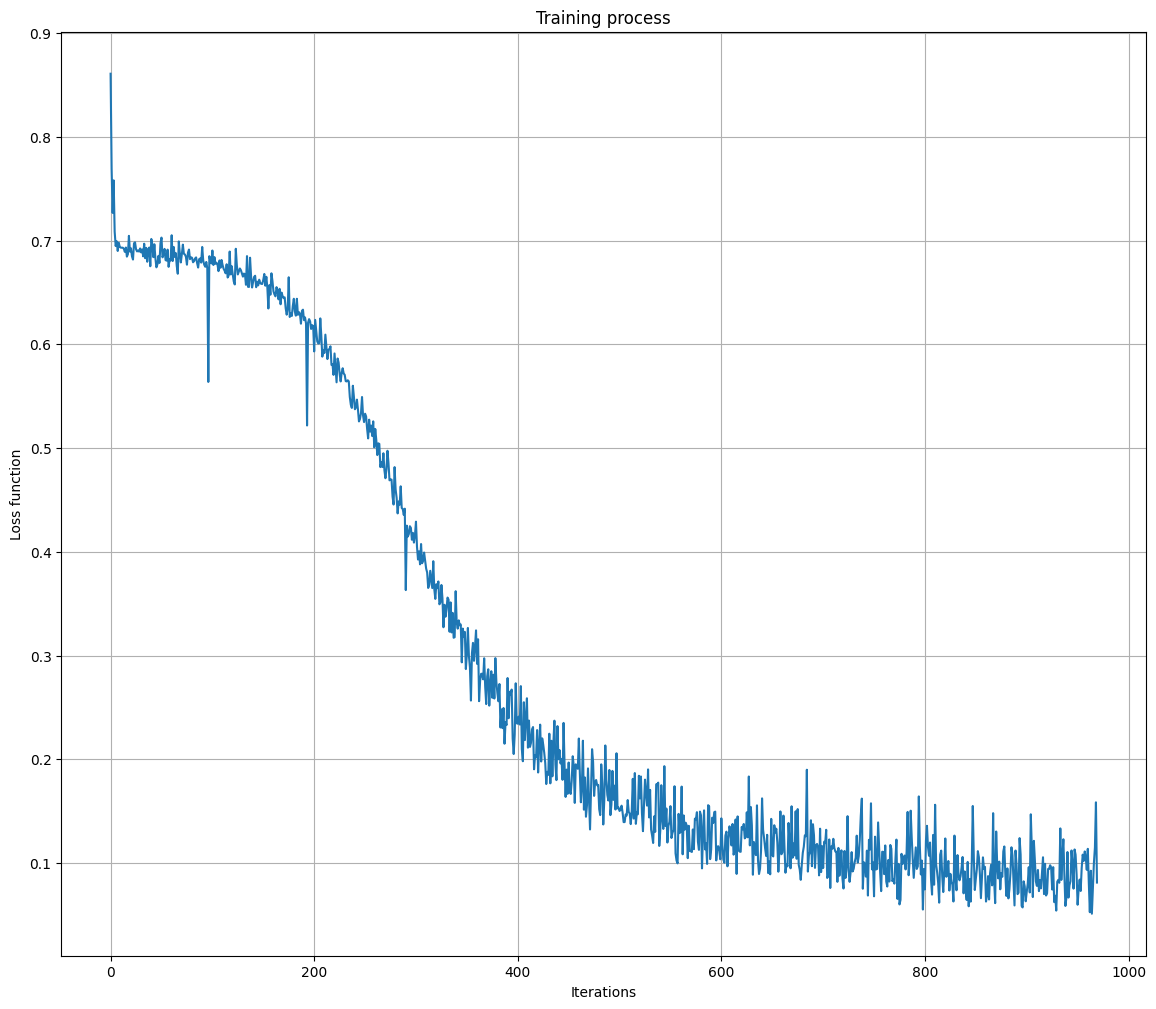

In [79]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Тестирование

А как это тестировать? Да, очень просто нужно просто выполнять форвард без бэкворда, то есть последовательно применять преобразования с обученными весами

In [80]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

  x = x.view(x.shape[0], -1).numpy()
  y = np.expand_dims(y.numpy(), 1)

  h1 = x.dot(w1) + b1 #переход в одномерное пространство
  p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"

  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
  #расчет энтропии с усреднением по размеру бача

  losses_test.append(bce)
  predicted.extend(p)
  true_lbls.extend(y)

Проверим, что для каждого семплау нас есть предсказание

In [81]:
print(len(predicted), len(true_lbls))

2038 2038


Теперь применим стандартную Ф меру и оценим нашу модель

In [83]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted])
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.90


Сделайте тоже самое для своей модели...

# Немного торча

In [84]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [85]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [86]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [87]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):

    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    #
    # передаем ссылку на самого себя первым параметром
    #
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    #
    def __init__(self, in_features, inner_features, out_features):

        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()

        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()

    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):

        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)

        return x

    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [88]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [89]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [90]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [91]:
# еще нам нужно задать функцию потерь
criterion = torch.nn.BCELoss()

In [92]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [93]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[ 0.0044, -0.0213,  0.0034,  ...,  0.0096, -0.0081,  0.0143],
         [ 0.0273,  0.0202,  0.0345,  ..., -0.0037,  0.0020, -0.0346],
         [-0.0250, -0.0010,  0.0323,  ...,  0.0064, -0.0061,  0.0246],
         ...,
         [ 0.0081, -0.0225,  0.0117,  ...,  0.0294, -0.0180,  0.0329],
         [ 0.0258,  0.0286, -0.0060,  ..., -0.0092, -0.0066, -0.0191],
         [-0.0320, -0.0154,  0.0025,  ..., -0.0287,  0.0034, -0.0062]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.8475e-02, -1.5634e-02, -1.7121e-02, -5.6813e-03, -1.3625e-02,
          1.6453e-02, -1.9689e-02,  6.3799e-03,  3.0297e-02,  6.3559e-03,
          2.3151e-03,  8.5844e-03, -1.8527e-02,  1.0886e-02,  1.3326e-02,
          1.0508e-03, -2.8739e-02,  1.9152e-03, -3.1263e-02, -1.1735e-02,
         -1.2359e-02,  5.9004e-03,  3.4596e-02,  3.2549e-03,  2.6389e-03,
          8.8374e-03,  1.7684e-02,  1.1136e-02,  2.6676e-02, -1.0866e-02,
         -2.7941e-02,  3.1765e-02,  1.14

# Обучим нашу модель

In [94]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()

    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    #
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    #
    optimizer.zero_grad()

    #
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    #
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    #
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    #
    pred = model(x)

    #
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    #
    loss = criterion(pred, y.float())

    #
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    #
    # то есть это почти то же самое, что мы делали в домашке с классами
    #
    loss.backward()

    #
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    #
    optimizer.step()

    #
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    #
    # для тензоров работает метод .tolist()
    #
    current_loss_value = loss.item()
    losses.append(loss.item())

In [95]:
# Одна эпоха прошла

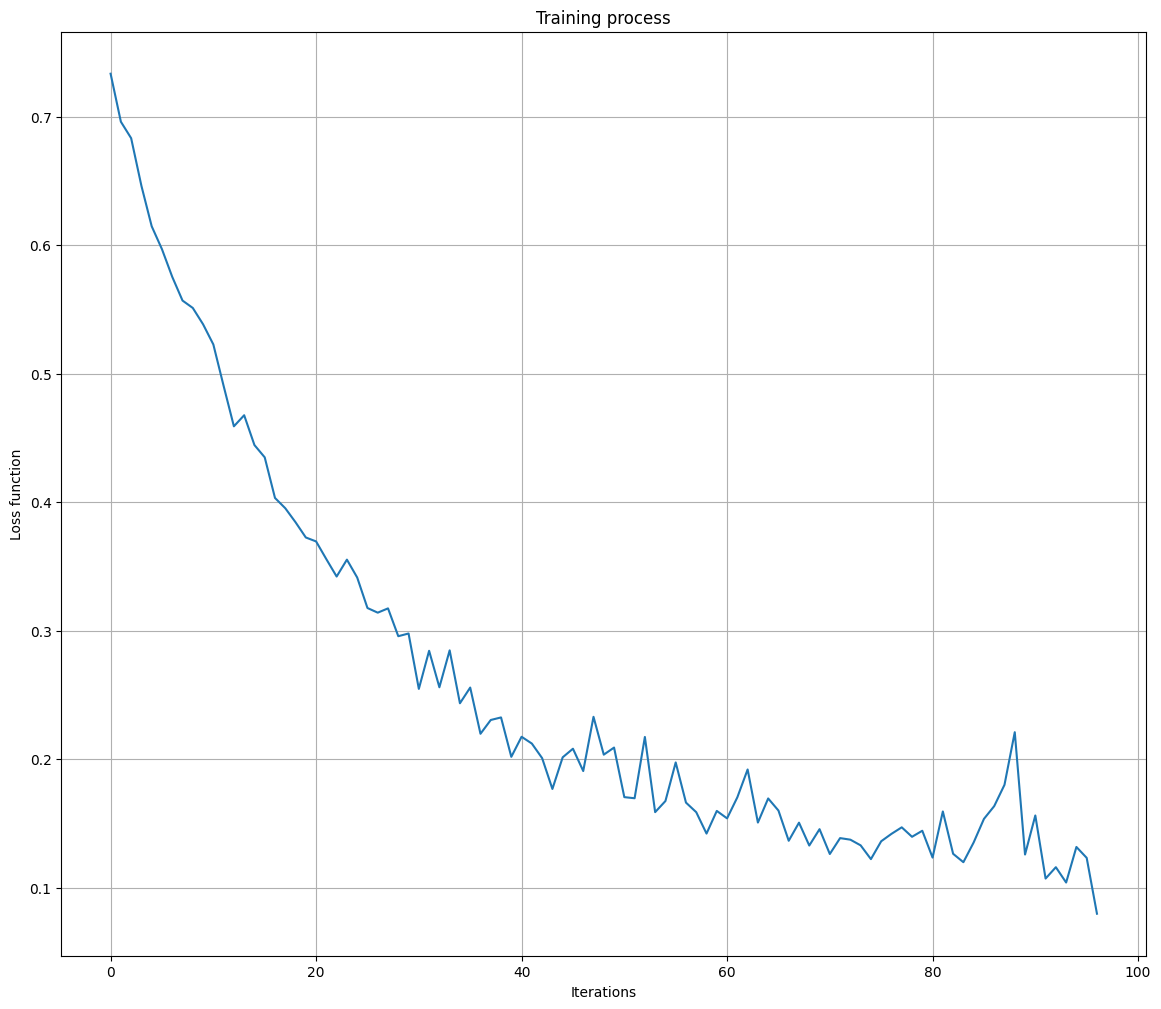

In [96]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [97]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()

    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [98]:
x.shape

torch.Size([128, 784])

In [99]:
y.shape

torch.Size([128, 1])

In [100]:
# переходим в режим предсказания
#
# позже в курсе мы разберем зачем конкретно это нужно
#
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
#
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [101]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [102]:
pred.shape

torch.Size([128, 1])

In [103]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [104]:
pred.shape

torch.Size([128])

In [105]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [106]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [107]:
type(y)

numpy.ndarray

In [108]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [109]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.9609375

In [110]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [111]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):

    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []

    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

    for x, y in train_loader:

        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        optimizer.zero_grad()

        pred = model(x)

        loss = criterion(pred, y.float())

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        losses.append(loss.item())

        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])

    progress_bar.close()

    for x, y in test_loader:

        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():

            pred = model(x)

        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())

    mean_test_loss = np.mean(test_losses)

    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()

    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0

    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))

    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1: 100%|██████████| 12396/12396 [00:06<00:00, 2039.69it/s, train_loss=0.0632]


Losses: train - 0.063, test = 0.046
Test: accuracy - 0.985


Epoch 2: 100%|██████████| 12396/12396 [00:03<00:00, 3826.54it/s, train_loss=0.0273]


Losses: train - 0.027, test = 0.032
Test: accuracy - 0.990


Epoch 3: 100%|██████████| 12396/12396 [00:03<00:00, 3993.61it/s, train_loss=0.0178]


Losses: train - 0.018, test = 0.029
Test: accuracy - 0.992


Epoch 4: 100%|██████████| 12396/12396 [00:03<00:00, 3942.53it/s, train_loss=0.0105]


Losses: train - 0.011, test = 0.021
Test: accuracy - 0.993


Epoch 5: 100%|██████████| 12396/12396 [00:03<00:00, 3414.95it/s, train_loss=0.00876]


Losses: train - 0.009, test = 0.021
Test: accuracy - 0.993


Epoch 6: 100%|██████████| 12396/12396 [00:03<00:00, 3975.04it/s, train_loss=0.00587]


Losses: train - 0.006, test = 0.019
Test: accuracy - 0.993


Epoch 7: 100%|██████████| 12396/12396 [00:03<00:00, 4059.95it/s, train_loss=0.00307]


Losses: train - 0.003, test = 0.019
Test: accuracy - 0.994
Early stopping


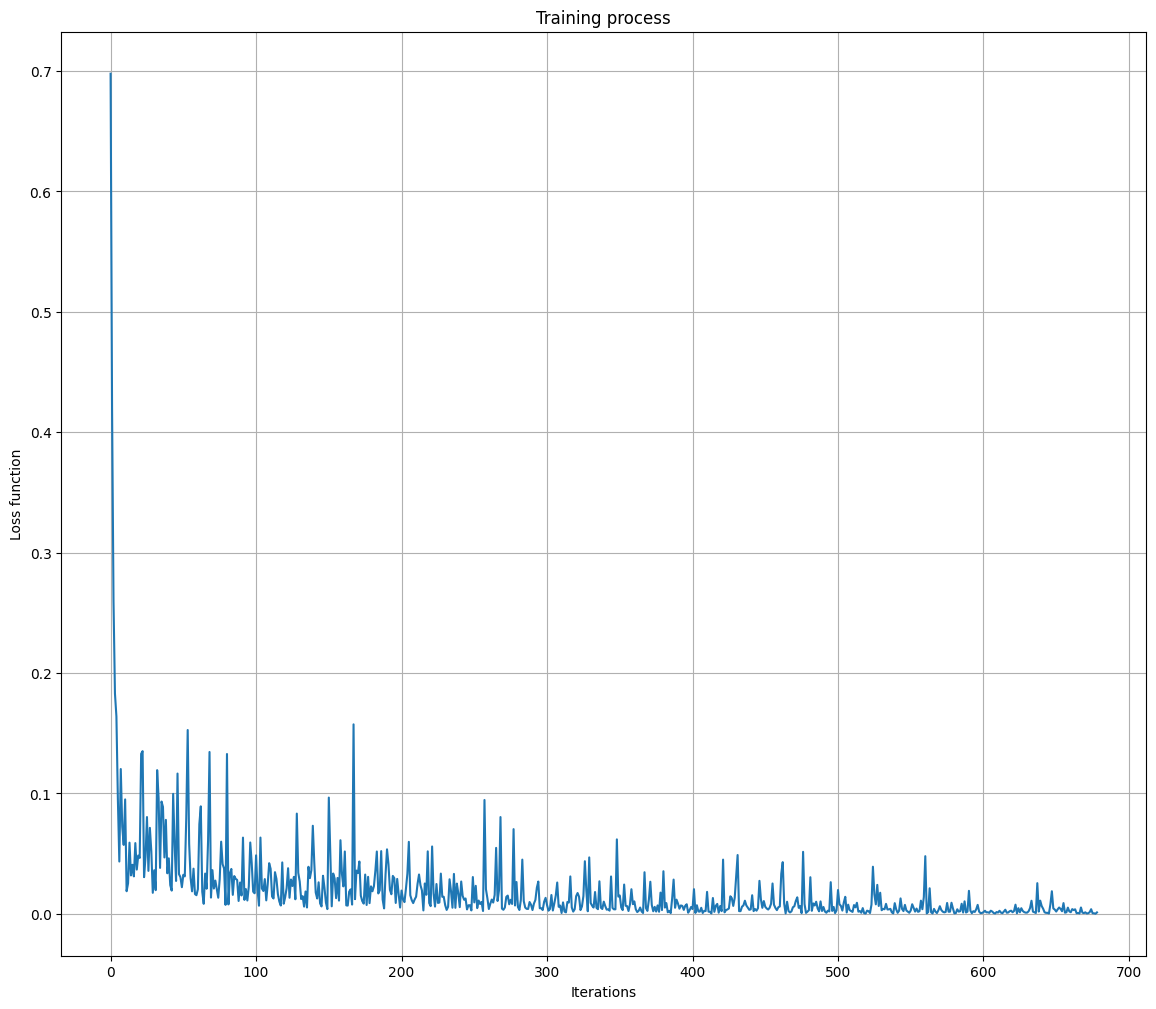

In [112]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');